In [ ]:
from pipelines import unet_train
from pipeline_config import SOLUTION_CONFIG

pipe = unet_train(SOLUTION_CONFIG)
pipe

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
masks = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_watershed_pipeline/outputs/thresholding')

In [ ]:
import pandas as pd
meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')
meta.head()

In [ ]:
filepaths_c = meta['file_path_contours'].values
filepaths_r = meta['file_path_image'].values

for i in range(10):
    plt.subplot(121)
    img = plt.imread(filepaths_c[i])
    plt.imshow(img)
    plt.subplot(122)
    img = plt.imread(filepaths_r[i])
    plt.imshow(img)
    plt.show()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from scipy.stats import itemfreq
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
watershed_contour = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/watershed_contour')
drop_smaller = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/drop_smaller')


for idx in np.random.choice(range(100),5):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    w = watershed_contour['detached_images'][idx]
    d = drop_smaller['labels'][idx]
    
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t) 
    plt.subplot(143)
    plt.imshow(random_colors(w),cmap='spectral')   
    plt.subplot(144)
    plt.imshow(random_colors(d),cmap='spectral')
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/watershed_contour'

In [ ]:
from tqdm import tqdm
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import itemfreq
from sklearn.externals import joblib
from skimage.transform import resize
import skimage.morphology as morph

from preparation import train_valid_split

def watershed_combined(image, contour, center):
    mask = np.where(contour + image == 2, 0, image)

    distance = ndi.distance_transform_edt(mask)
    markers, nr_blobs = ndi.label(mask)
    labeled = morph.watershed(-distance, markers, mask=image)

    dropped, _ = ndi.label(image - (labeled > 0))
    dropped = np.where(dropped > 0, dropped + nr_blobs, 0)
    correct_labeled = dropped + labeled

    return correct_labeled
    
mask_threshold = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/mask_thresholding')
contour_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/contour_thresholding')
center_thresholding = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/unet_multitask/outputs/center_thresholding')

for idx in np.random.choice(range(100),50):
    m = mask_threshold['binarized_images'][idx]
    t = contour_thresholding['binarized_images'][idx]
    c = center_thresholding['binarized_images'][idx]
    wc = watershed_combined(m,t,c)
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(t)
    plt.subplot(143)
    plt.imshow(c)   
    plt.subplot(144)
    plt.imshow(random_colors(wc),cmap='nipy_spectral') 
    plt.show()

In [ ]:
?plt.imsave

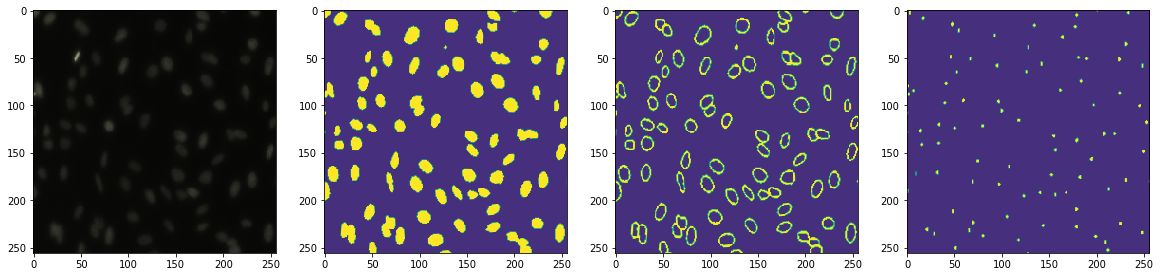

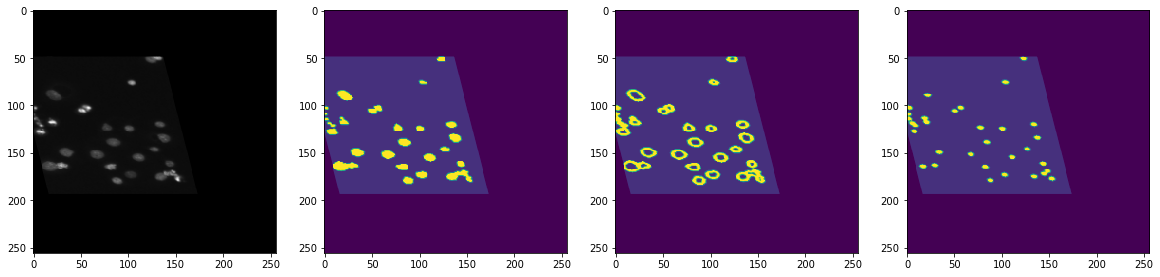

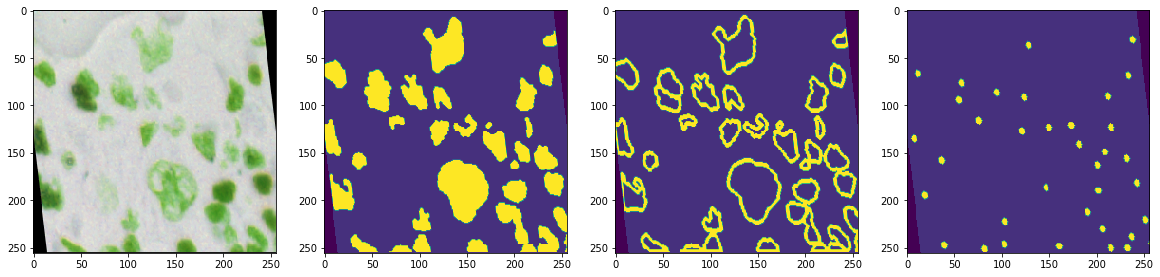

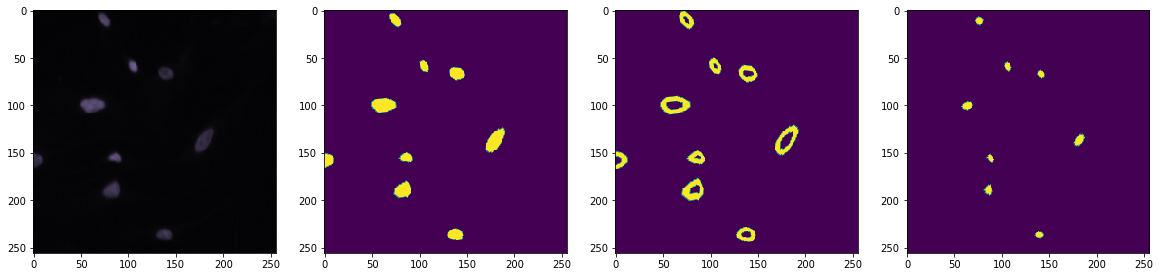

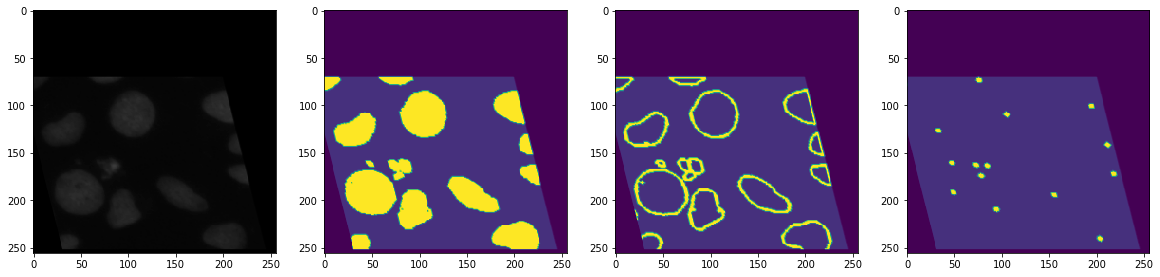

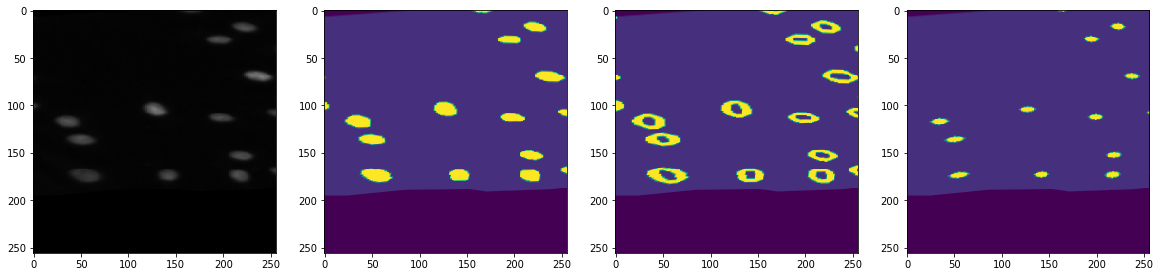

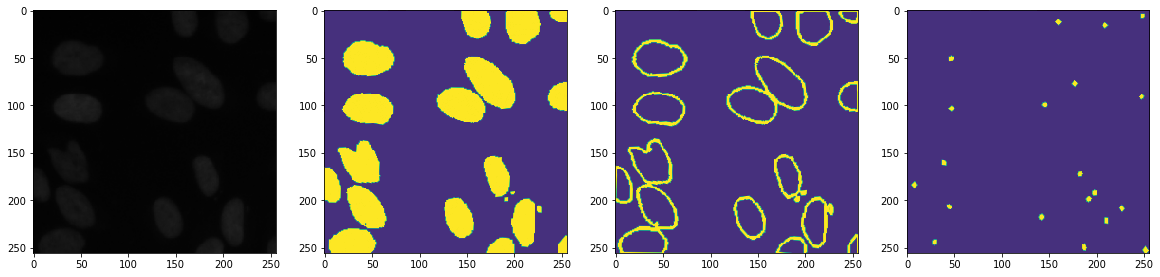

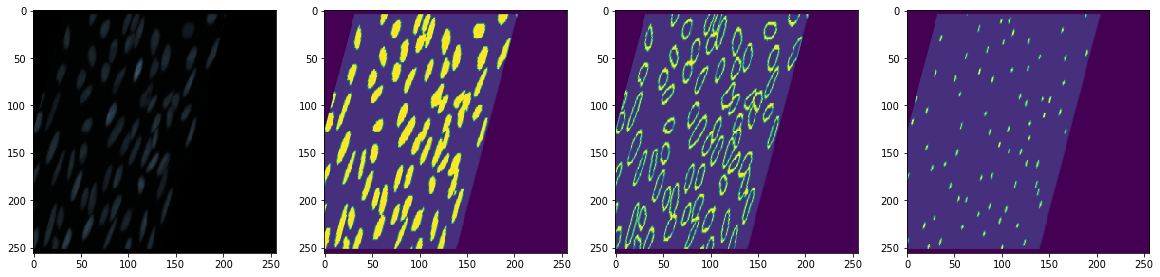

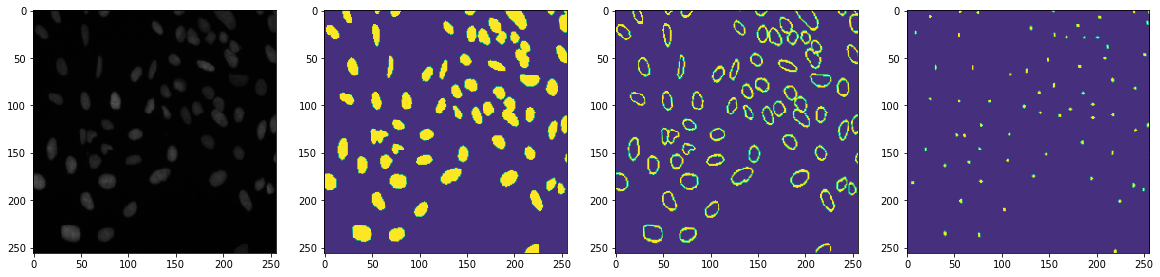

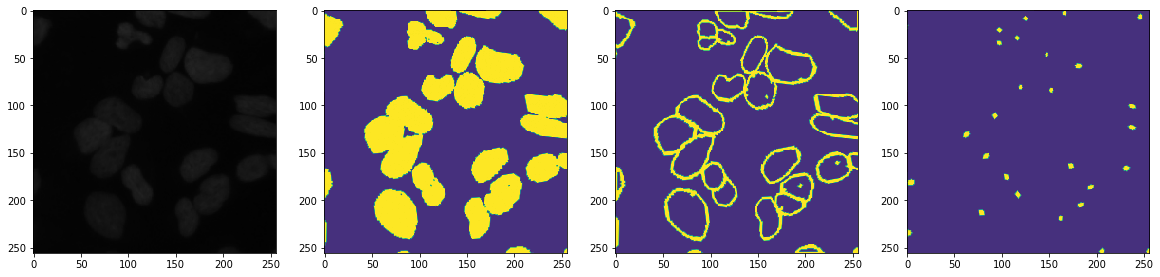

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    r = plt.imread( '/mnt/ml-team/minerva/debug/raw{}.jpg'.format(i))
    m = plt.imread( '/mnt/ml-team/minerva/debug/mask{}.jpg'.format(i))
    t = plt.imread( '/mnt/ml-team/minerva/debug/contour{}.jpg'.format(i))
    c = plt.imread( '/mnt/ml-team/minerva/debug/center{}.jpg'.format(i))
    plt.figure(figsize=(20,10))
    plt.subplot(141)
    plt.imshow(r)
    plt.subplot(142)
    plt.imshow(m)
    plt.subplot(143)
    plt.imshow(t)
    plt.subplot(144)
    plt.imshow(c)
    plt.show()

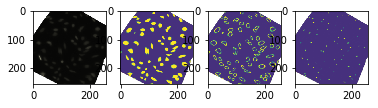

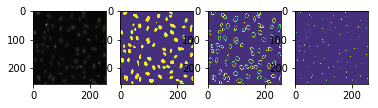

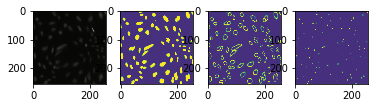

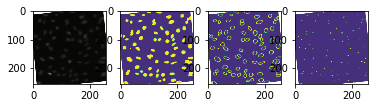

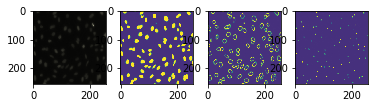

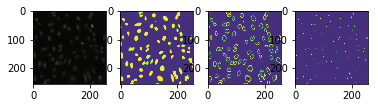

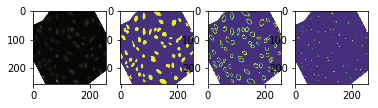

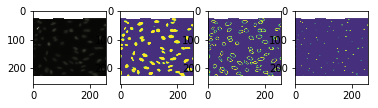

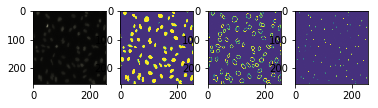

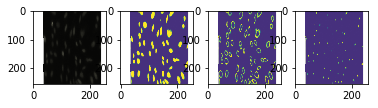

In [2]:
# from steps.pytorch.utils import ImgAug
from imgaug import augmenters as iaa

from augmentation import affine_seq
from utils import from_pil, to_pil

class ImgAug:
    def __init__(self, augmenters):
        if not isinstance(augmenters, list):
            augmenters = [augmenters]
        self.augmenters = augmenters
        self.seq_det = None

    def _pre_call_hook(self):
        seq = iaa.Sequential(self.augmenters)
        seq = seq.to_deterministic()
        seq.reseed()
        self.seq_det = seq

    def transform(self, *images):
        images = [self.seq_det.augment_image(image) for image in images]
        if len(images) == 1:
            return images[0]
        else:
            return images

    def __call__(self, *args):
        self._pre_call_hook()
        return self.transform(*args)

augmenter = ImgAug(affine_seq)

for i in range(10):
    r_,m_,t_,c_ = from_pil(r,m,t,c)
    r_,m_,t_,c_ = augmenter(r_,m_,t_,c_)
    plt.subplot(141)
    plt.imshow(r_)
    plt.subplot(142)
    plt.imshow(m_)
    plt.subplot(143)
    plt.imshow(t_)
    plt.subplot(144)
    plt.imshow(c_)
    plt.show()

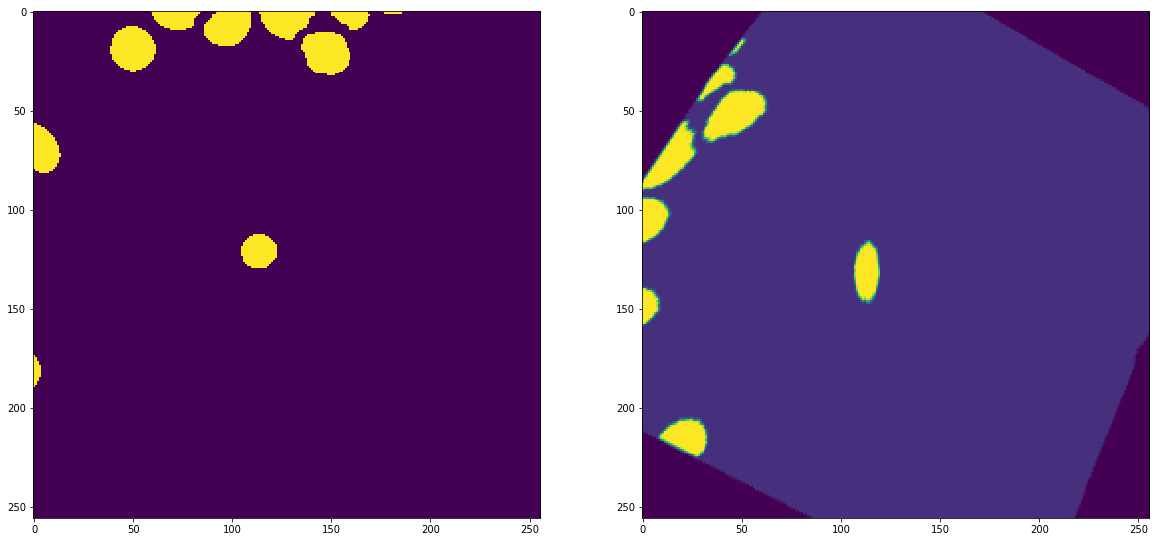

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug import augmenters as iaa
import numpy as np
from sklearn.externals import joblib

pre = np.array(joblib.load('/mnt/ml-team/minerva/debug/pre.pkl'))
post = np.array(joblib.load('/mnt/ml-team/minerva/debug/post.pkl'))

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(pre)
plt.subplot(122)
plt.imshow(post)
plt.show()

In [ ]:
?iaa.to